# Comparing model performance on filtering procedures with multiple metrics

### Imports and setup

In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import AtlasAnalysisFunctions as AAF

In [5]:
# Functions to store and retrieve class instances
def save_class_to_file(filename, object):
    with open(f"objects/{filename}.pkl", "wb") as filehandler:
        pickle.dump(object, filehandler, pickle.HIGHEST_PROTOCOL)

def open_file_to_class(file_name):
    with open(f'objects/{file_name}.pkl', 'rb') as filehandler:
        return pickle.load(filehandler)

---

### Initializing datasets

In [6]:
# Minimal preprocessing
base = pd.read_csv("base_ML_dataset.csv")
metadata = base.iloc[:, -2:]
metadata = metadata.reset_index().rename(columns = {"index": "assay_id"})
metadata.loc[metadata.tissue_type == "T-cell", "tissue_type"] = "blood"
labels = base.pop("tissue_type")
data = base.iloc[:, :-1]
data.fillna(0, inplace = True)
data.head()
full_df = pd.concat([data, labels], axis = 1)
full_df = full_df[~full_df.tissue_type.isin(["trophoblast","prostate", "fetal kidney", "lung", "fibroblast", "/"])]
full_df.loc[full_df.tissue_type == "T-cell", ["tissue_type"]] = "blood"
labels = full_df.pop("tissue_type")
data = full_df
metadata = metadata.loc[metadata.index.isin(data.index),:]

Global filtering

In [4]:
f25_global = AAF.ModelModule(data, metadata)
f25_global.set_labels("tissue_type")
f25_global.filter_dataset("reoccur global", percentage_reoccurence=.25)

f50_global = AAF.ModelModule(data, metadata)
f50_global.set_labels("tissue_type")
f50_global.filter_dataset("reoccur global", percentage_reoccurence=.50)

f75_global = AAF.ModelModule(data, metadata)
f75_global.set_labels("tissue_type")
f75_global.filter_dataset("reoccur global", percentage_reoccurence=.75)

Filtered dataset on reoccur global stored in 'filtered_dataset'
Filtered dataset on reoccur global stored in 'filtered_dataset'
Filtered dataset on reoccur global stored in 'filtered_dataset'


Local filtering

In [4]:
f50_local = AAF.ModelModule(data, metadata)
f50_local.set_labels("tissue_type")
f50_local.filter_dataset("reoccur local", percentage_reoccurence=.50)

Filtered dataset on reoccur local stored in 'filtered_dataset'


In [10]:
f25_local = AAF.ModelModule(data, metadata)
f25_local.set_labels("tissue_type")
f25_local.filter_dataset("reoccur local", percentage_reoccurence=.25)

f50_local = AAF.ModelModule(data, metadata)
f50_local.set_labels("tissue_type")
f50_local.filter_dataset("reoccur local", percentage_reoccurence=.50)

f75_local = AAF.ModelModule(data, metadata)
f75_local.set_labels("tissue_type")
f75_local.filter_dataset("reoccur local", percentage_reoccurence=.75)

Filtered dataset on reoccur local stored in 'filtered_dataset'
Filtered dataset on reoccur local stored in 'filtered_dataset'
Filtered dataset on reoccur local stored in 'filtered_dataset'


No filtering

In [5]:
base_dataset = AAF.ModelModule(data, metadata)
base_dataset.set_labels("tissue_type")

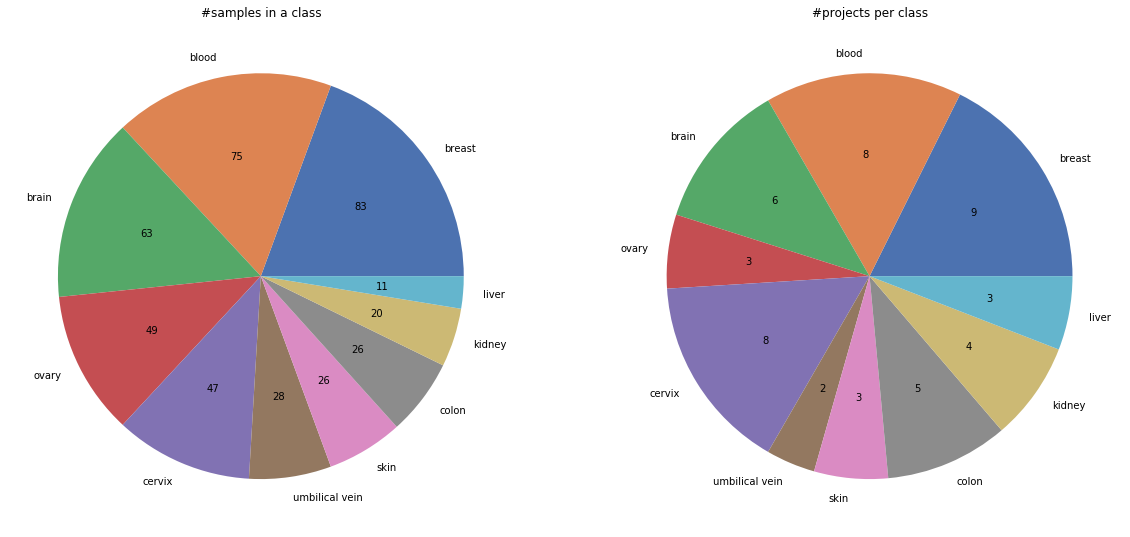

In [18]:
apc = metadata.tissue_type.value_counts(sort = True)
label_order = apc.index
ppc = metadata.groupby("tissue_type", sort = False).nunique().PXD_accession[label_order]

fig = plt.figure(figsize=(20,10))
fig.set_facecolor("white")

plt.subplot(121)
plt.title("#samples in a class")
_ = plt.pie(apc.values, labels = label_order.values, colors = sns.color_palette("deep"),
autopct= lambda p: '{:.0f}'.format(p*sum(apc.values)/100))

plt.subplot(122)
plt.title(r"#projects per class")
_ = plt.pie(ppc.values, labels = label_order.values, colors = sns.color_palette("deep"),
autopct = lambda p: '{:.0f}'.format(p*sum(ppc.values)/100))

---

### Setting up the models and parameter grids

In [7]:
weights = {}
all = labels.value_counts().sum()
for index, row in labels.value_counts().reset_index().iterrows():
    weights[row["index"]] = all/(labels.nunique()*row["tissue_type"])


In [12]:
# Models to be used:

lr = LogisticRegression(class_weight=weights)
svc = SVC(class_weight=weights)
rf = RandomForestClassifier(class_weight=weights)
gnb = GaussianNB()
xgb = XGBClassifier() # Requires encoding the labels (done later)
models = {"lr": lr, "svc": svc, "rf": rf, "gnb": gnb}

# Parameter grids

lr_grid = {"penalty" : ['l2'],
            "class_weight": ["balanced"],
            "C": np.linspace(0.005, 5, 5)}

svc_grid = {'decision_function_shape': ["ovr"],
            "kernel": ['linear', 'poly', 'rbf'],
            "C": np.linspace(0.0005, 5, 10),
            "class_weight": [weights]}

rf_grid = {'n_estimators': np.linspace(10, 200, 4, dtype = int),
            "criterion": ["entropy"], 
            "max_depth": [10,20,40, None],
            "class_weight": [weights]}

gnb_grid = {'var_smoothing': np.logspace(0,-15,15)}

xgb_grid = {"verbosity": [0],
            'eta': np.linspace(0.005,0.5,5),
            'gamma': np.linspace(0.005,10,5),
            'max_depth': [3,5,7,10]}

grids = {"lr": lr_grid, "svc": svc_grid, "rf": rf_grid, "gnb": gnb_grid}

In [8]:
base_dataset.initialize_models(models)
base_dataset.initialize_grid(grids)

Models initialized.
Models: dict_keys(['lr', 'svc', 'rf', 'gnb'])
Grids initialized.


In [7]:
f25_global.initialize_models(models)
f50_global.initialize_models(models)
f75_global.initialize_models(models)

f25_global.initialize_grid(grids)
f50_global.initialize_grid(grids)
f75_global.initialize_grid(grids)

Models initialized.
Models: dict_keys(['lr', 'svc', 'rf', 'gnb'])
Models initialized.
Models: dict_keys(['lr', 'svc', 'rf', 'gnb'])
Models initialized.
Models: dict_keys(['lr', 'svc', 'rf', 'gnb'])
Grids initialized.
Grids initialized.
Grids initialized.


In [15]:
f25_local.initialize_models(models)
f50_local.initialize_models(models)
f75_local.initialize_models(models)

f25_local.initialize_grid(grids)
f50_local.initialize_grid(grids)
f75_local.initialize_grid(grids)

Grids initialized.
Grids initialized.
Grids initialized.
Grids initialized.
Grids initialized.
Grids initialized.
Grids initialized.


In [9]:
skf = StratifiedKFold(10)
pbkf = AAF.ProjectBasedSplit(10, metadata.reset_index(drop = True), "tissue_type")

---

### Comparing model performance on the different datasets

Local filtering datasets

- stratified kfold splits

In [17]:
f25_local.compare_models(dataset_type="filtered", models="init", splitting_procedure=skf, name_results_file='f25_local_skf')
print("25 skf done")
f50_local.compare_models(dataset_type="filtered", models="init", splitting_procedure=skf, name_results_file='f50_local_skf')
print("50 skf done")
f75_local.compare_models(dataset_type="filtered", models="init", splitting_procedure=skf, name_results_file='f75_local_skf')
print("75 skf done")

Comparing results done. See the results in results/comparison_f25_local_skf.csv
Comparing results done. See the results in results/comparison_f25_local_skf.csv
Comparing results done. See the results in results/comparison_f25_local_skf.csv
Comparing results done. See the results in results/comparison_f25_local_skf.csv
25 skf done
Comparing results done. See the results in results/comparison_f50_local_skf.csv
Comparing results done. See the results in results/comparison_f50_local_skf.csv
Comparing results done. See the results in results/comparison_f50_local_skf.csv
Comparing results done. See the results in results/comparison_f50_local_skf.csv
50 skf done
Comparing results done. See the results in results/comparison_f75_local_skf.csv
Comparing results done. See the results in results/comparison_f75_local_skf.csv
Comparing results done. See the results in results/comparison_f75_local_skf.csv
Comparing results done. See the results in results/comparison_f75_local_skf.csv
75 skf done


TypeError: Expected sequence or array-like, got <class 'NoneType'>

- whole project splits

In [18]:
f25_local.compare_models(dataset_type="filtered", models="init", splitting_procedure=pbkf, name_results_file='f25_local_pbkf')
print("25 pbkf done")
f50_local.compare_models(dataset_type="filtered", models="init", splitting_procedure=pbkf, name_results_file='f50_local_pbkf')
print("50 pbkf done")
f75_local.compare_models(dataset_type="filtered", models="init", splitting_procedure=pbkf, name_results_file='f75_local_pbkf')
print("75 pbkf done")


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "

Comparing results done. See the results in results/comparison_f25_local_pbkf.csv


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "

Comparing results done. See the results in results/comparison_f25_local_pbkf.csv


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "

Comparing results done. See the results in results/comparison_f25_local_pbkf.csv


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "

Comparing results done. See the results in results/comparison_f25_local_pbkf.csv
25 pbkf done


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "

Comparing results done. See the results in results/comparison_f50_local_pbkf.csv


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "

Comparing results done. See the results in results/comparison_f50_local_pbkf.csv


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "

Comparing results done. See the results in results/comparison_f50_local_pbkf.csv


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "

Comparing results done. See the results in results/comparison_f50_local_pbkf.csv
50 pbkf done


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "

Comparing results done. See the results in results/comparison_f75_local_pbkf.csv


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "

Comparing results done. See the results in results/comparison_f75_local_pbkf.csv


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "

Comparing results done. See the results in results/comparison_f75_local_pbkf.csv


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "

Comparing results done. See the results in results/comparison_f75_local_pbkf.csv
75 pbkf done


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


No filtering

In [18]:
base_dataset.compare_models(dataset_type="base", models="init", splitting_procedure=skf, name_results_file='base_skf')
print("base skf done")
base_dataset.compare_models(dataset_type="base", models="init", splitting_procedure=pbkf, name_results_file='base_pbkf')
print("base pbkf done")

Comparing results done. See the results in results/comparison_base_skf.csv
Comparing results done. See the results in results/comparison_base_skf.csv
Comparing results done. See the results in results/comparison_base_skf.csv
Comparing results done. See the results in results/comparison_base_skf.csv
base skf done


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "

Comparing results done. See the results in results/comparison_base_pbkf.csv


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "

Comparing results done. See the results in results/comparison_base_pbkf.csv


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "

Comparing results done. See the results in results/comparison_base_pbkf.csv


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "

Comparing results done. See the results in results/comparison_base_pbkf.csv
base pbkf done


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Global filtering datasets

- stratified kfold splits

In [19]:
f25_global.compare_models(dataset_type="filtered", models="init", splitting_procedure=skf, name_results_file='f25_global_skf')
print("25 skf done")
f50_global.compare_models(dataset_type="filtered", models="init", splitting_procedure=skf, name_results_file='f50_global_skf')
print("50 skf done")
f75_global.compare_models(dataset_type="filtered", models="init", splitting_procedure=skf, name_results_file='f75_global_skf')
print("75 skf done")


Comparing results done. See the results in results/comparison_f25_global_skf.csv
Comparing results done. See the results in results/comparison_f25_global_skf.csv
Comparing results done. See the results in results/comparison_f25_global_skf.csv
Comparing results done. See the results in results/comparison_f25_global_skf.csv
25 skf done
Comparing results done. See the results in results/comparison_f50_global_skf.csv
Comparing results done. See the results in results/comparison_f50_global_skf.csv
Comparing results done. See the results in results/comparison_f50_global_skf.csv
Comparing results done. See the results in results/comparison_f50_global_skf.csv
50 skf done
Comparing results done. See the results in results/comparison_f75_global_skf.csv
Comparing results done. See the results in results/comparison_f75_global_skf.csv
Comparing results done. See the results in results/comparison_f75_global_skf.csv
Comparing results done. See the results in results/comparison_f75_global_skf.csv
75 s

- whole project splits

In [20]:
f25_global.compare_models(dataset_type="filtered", models="init", splitting_procedure=pbkf, name_results_file='f25_global_pbkf')
print("25 pbkf done")
f50_global.compare_models(dataset_type="filtered", models="init", splitting_procedure=pbkf, name_results_file='f50_global_pbkf')
print("50 pbkf done")
f75_global.compare_models(dataset_type="filtered", models="init", splitting_procedure=pbkf, name_results_file='f75_global_pbkf')
print("75 pbkf done")

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "

Comparing results done. See the results in results/comparison_f25_global_pbkf.csv


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "

Comparing results done. See the results in results/comparison_f25_global_pbkf.csv


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "

Comparing results done. See the results in results/comparison_f25_global_pbkf.csv


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "

Comparing results done. See the results in results/comparison_f25_global_pbkf.csv
25 pbkf done


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "

Comparing results done. See the results in results/comparison_f50_global_pbkf.csv


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "

Comparing results done. See the results in results/comparison_f50_global_pbkf.csv


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "

Comparing results done. See the results in results/comparison_f50_global_pbkf.csv


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "

Comparing results done. See the results in results/comparison_f50_global_pbkf.csv
50 pbkf done


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "

Comparing results done. See the results in results/comparison_f75_global_pbkf.csv


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "

Comparing results done. See the results in results/comparison_f75_global_pbkf.csv


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "

Comparing results done. See the results in results/comparison_f75_global_pbkf.csv


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "

Comparing results done. See the results in results/comparison_f75_global_pbkf.csv
75 pbkf done


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


## Evaluate data leakage of the filtering

### 1. Perform filtering on dataset with shuffled labels

Irrelevant classes are generated, keeping the class imbalance in mind. The performance should be bad, otherwise this indicates the filtering technique generates the class specific features in itself.

In [20]:
shuffled_dataset = AAF.ModelModule(data, metadata)
shuffled_dataset.dataset = shuffled_dataset.dataset.sample(frac = 1, random_state=1).reset_index() # Shuffle the dataset
shuffled_dataset.shuffle_mapping = shuffled_dataset.dataset.pop("index")
shuffled_dataset.set_labels('tissue_type')

In [21]:
shuffled_dataset.shuffle_mapping.head()

0    227
1    208
2    164
3    277
4     62
Name: index, dtype: int64

In [22]:
shuffled_dataset.filter_dataset("reoccur global", percentage_reoccurence=.50)
shuffled_dataset.initialize_models(models)
shuffled_dataset.initialize_grid(grids)
shuffled_dataset.compare_models(dataset_type="filtered", models="init", splitting_procedure=skf, name_results_file='f50shuffle_global_skf')
shuffled_dataset.compare_models(dataset_type="filtered", models="init", splitting_procedure=pbkf, name_results_file='f50shuffle_global_pbkf')

Filtered dataset on reoccur global stored in 'filtered_dataset'
Models initialized.
Models: dict_keys(['lr', 'svc', 'rf', 'gnb'])
Grids initialized.
Comparing results done. See the results in results/comparison_f50shuffle_global_skf.csv
Comparing results done. See the results in results/comparison_f50shuffle_global_skf.csv
Comparing results done. See the results in results/comparison_f50shuffle_global_skf.csv
Comparing results done. See the results in results/comparison_f50shuffle_global_skf.csv


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "

Comparing results done. See the results in results/comparison_f50shuffle_global_pbkf.csv


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "

Comparing results done. See the results in results/comparison_f50shuffle_global_pbkf.csv


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "

Comparing results done. See the results in results/comparison_f50shuffle_global_pbkf.csv


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "

Comparing results done. See the results in results/comparison_f50shuffle_global_pbkf.csv


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


### 2. Only filter the train set

In [11]:
train_filter_only = AAF.ModelModule(data, metadata)
train_filter_only.set_labels('tissue_type')
train_filter_only.initialize_models(models)
train_filter_only.initialize_grid(grids)
train_filter_only.compare_models(dataset_type="base", models = "init", splitting_procedure=skf, name_results_file="train_f50_skf", 
                filter_trainset_only=True, percentage_reoccurence=.5)
train_filter_only.compare_models(dataset_type="base", models = "init", splitting_procedure=pbkf, name_results_file="train_f50_pbkf", 
                filter_trainset_only=True, percentage_reoccurence=.5)

Models initialized.
Models: dict_keys(['lr', 'svc', 'rf', 'gnb'])
Grids initialized.
LogisticRegression
1
2
3
4
5
6
7
8
9
10
Comparing results done. See the results in results/comparison_train_f50_skf.csv
SVC
1
2
3
4
5
6
7
8
9
10
Comparing results done. See the results in results/comparison_train_f50_skf.csv
RandomForestClassifier
1
2
3
4
5
6
7
8
9
10
Comparing results done. See the results in results/comparison_train_f50_skf.csv
GaussianNB
1
2
3
4
5
6
7
8
9
10
Comparing results done. See the results in results/comparison_train_f50_skf.csv
LogisticRegression
1
2
3
4


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


5
6


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


7


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


8


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


9


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


10


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Comparing results done. See the results in results/comparison_train_f50_pbkf.csv
SVC
1


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


3


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


4


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


5


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


6


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


7


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


8


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


9


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


10
Comparing results done. See the results in results/comparison_train_f50_pbkf.csv
RandomForestClassifier
1


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


3


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


4


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


5


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


6


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


7


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


8


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


9


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


10


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Comparing results done. See the results in results/comparison_train_f50_pbkf.csv
GaussianNB
1


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


3


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


4
5


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


6
7


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


8


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


9


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


10
Comparing results done. See the results in results/comparison_train_f50_pbkf.csv


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


---

### Try scaling the dataset

In [ ]:
f50_global = AAF.ModelModule(data, metadata)
f50_global.set_labels("tissue_type")
f50_global.filter_dataset("reoccur global", percentage_reoccurence=.50)
f50_global.initialize_models(models)
f50_global.initialize_grid(grids)

In [ ]:
scaler = StandardScaler()
new =scaler.fit_transform(f50_global.filtered_dataset)
f50_global.filtered_dataset = pd.DataFrame(new, columns = f50_global.filtered_dataset.columns)

In [29]:
f50_global.compare_models(dataset_type="filtered", models="init", splitting_procedure=pbkf, name_results_file='f50_global_pbkf_scaled')

LogisticRegression
1


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


3


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


4


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


5


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


6


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


7


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


8


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


9


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


10


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Comparing results done. See the results in results/comparison_f50_global_pbkf_scaled.csv
SVC
1


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


3


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


4


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


5


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


6


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


7


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


8


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


9


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


10


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Comparing results done. See the results in results/comparison_f50_global_pbkf_scaled.csv
RandomForestClassifier
1


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


3


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


4


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


5


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


6


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


7


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


8


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


9


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


10


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Comparing results done. See the results in results/comparison_f50_global_pbkf_scaled.csv
GaussianNB
1


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


2


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


3


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


4


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


5


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


6


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


7


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


8


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


9


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


10
Comparing results done. See the results in results/comparison_f50_global_pbkf_scaled.csv


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


---

### Find best hyperparameters for SVM on scaled dataset

Goal: Evaluate the effect of more generalization on the performance

In [10]:
f50_global = AAF.ModelModule(data, metadata)
f50_global.set_labels("tissue_type")
f50_global.filter_dataset("reoccur global", percentage_reoccurence=.50)

Filtered dataset on reoccur global stored in 'filtered_dataset'


In [13]:
f50_global.initialize_models(models)
f50_global.initialize_grid(grids)

Models initialized.
Models: dict_keys(['lr', 'svc', 'rf', 'gnb'])
Grids initialized.


In [15]:
#base_dataset.nested_grid_search(filtered = True, model_names = ["svc", "rf"], splitting_procedure=(skf, "project"), 
#gridsearch_scoring='project_norm', name_results_file="base_skf_pbkf_pn", outerloop_cv= 10, innerloop_cv=5)
f50_global.filtered_dataset
f50_global.nested_grid_search(filtered = True, model_names = ["svc"], splitting_procedure=(skf, skf), 
gridsearch_scoring='project_norm', name_results_file="base_skf_pbkf_pn", outerloop_cv= 10, innerloop_cv=7)

Start evaluation: svc
CV: 1/10
Gridsearch scores: dict_values([0.7111111111111111, 1.0, 1.0, 1.0, 0.9555555555555556, 0.7976190476190476, 0.7467948717948718])
CV: 2/10
Gridsearch scores: dict_values([0.725, 0.9333333333333333, 1.0, 1.0, 0.9555555555555556, 0.8452380952380952, 0.7339743589743589])
CV: 3/10


KeyboardInterrupt: 

---

Evaluating feature importance of a model

In [19]:
model = GaussianNB()

model.fit(f50_local.filtered_dataset, f50_local.labels)

GaussianNB()

In [ ]:
from sklearn.inspection import permutation_importance

feature_importance = permutation_importance(model, f50_local.filtered_dataset, f50_local.labels)

In [22]:
randomf = RandomForestClassifier(200, criterion = "entropy")
randomf.fit(f50_local.filtered_dataset, f50_local.labels)

RandomForestClassifier(criterion='entropy', n_estimators=200)

In [24]:
importances = randomf.feature_importances_
indices = np.argsort(importances)

In [35]:
np.argsort(importances)


array([   0, 8308, 8309, ..., 7274, 2679, 1823])

In [34]:
importances[1823]

0.008369406930058337

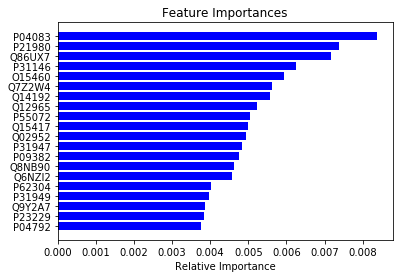

In [36]:
importances = randomf.feature_importances_
indices = np.argsort(importances)
features = f50_local.filtered_dataset.columns
plt.title('Feature Importances')
plt.barh(range(len(indices[-20:])), importances[indices[-20:]], color='b', align='center')
plt.yticks(range(len(indices[-20:])), [features[i] for i in indices[-20:]])
plt.xlabel('Relative Importance')
plt.show()
